In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # surpress warning and info messages
import matplotlib.pyplot as plt
import tensorflow as tf
from os.path import *
import pandas as pd
import numpy as np
import json
import glob
import sys

sys.path.append('../Model')
sys.path.append('../DataGenerators')
from data_generator import DataGenerator

In [5]:
def get_running_times(root):
    with open(f'{root}POWER/metadata.json', 'r') as f: # the running time of both datasets are identical
        metadata = json.load(f)
        max =  metadata['max_running_time']
        min =  metadata['min_running_time']
        return max,min

# builds a dataframe with the path and class of each sample
def get_samples(root):
    samples_df = pd.DataFrame(columns=["path", "class", "numeric_class"])
    samples_path = []
    samples_class = []

    for filename in glob.iglob(root + '**/*.npy', recursive=True):
        clas = basename(dirname(filename)) # folder name is the name of the class
        samples_path.append(filename)
        samples_class.append(clas)

    samples_df["path"] = samples_path
    samples_df["class"] = samples_class

    unique_classes = samples_df["class"].copy().drop_duplicates().sort_values(ignore_index=True)
    samples_df['numeric_class'] = samples_df['class'].apply(lambda class_name: unique_classes[unique_classes == class_name].index[0])

    return samples_df, unique_classes
    

In [ ]:
accuracies = []
dataset_path = "../testset/"
n_classes = 24
noise_strength = 0

max_running_time, min_running_time = get_running_times(dataset_path)

em_samples_df, _ = get_samples(f'{dataset_path}EM/')
power_samples_df, _ = get_samples(f'{dataset_path}POWER/')

for noise_strength in range(0,21):
    em_test_generator = DataGenerator(em_samples_df , n_classes=n_classes, max_running_time=max_running_time, min_running_time=min_running_time, win_size=3, sampling_rate=56000000, sigma=noise_strength)
    power_test_generator = DataGenerator(power_samples_df , n_classes=n_classes, max_running_time=max_running_time, min_running_time=min_running_time, win_size=30, sampling_rate=1000000000, sigma=noise_strength)

    # load models
    em_model = tf.keras.models.load_model(f"../trained_models/single_channel/em_{noise_strength}")
    power_model = tf.keras.models.load_model(f"../trained_models/single_channel/power_{noise_strength}")

    # predict
    em_test_probas = em_model.predict(em_test_generator, verbose=1)
    power_test_probas = power_model.predict(power_test_generator, verbose=1)

    # order of the samples is the same in the test generators so this is legal
    output_vector = ((em_test_probas + power_test_probas)/2)

    y_pred = np.argmax(output_vector, axis=1)
    y_true = em_test_generator.y_true

    accuracy = sum(y_pred == y_true) / len(y_true)
    accuracies.append(accuracy)
    print(f"Noise: {noise_strength}, Accuracy: {accuracy}")

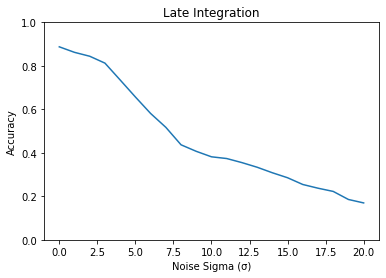

In [7]:
plt.plot(range(0,21), accuracies)
plt.title("Late Integration")
plt.xlabel(f'Noise Sigma (\u03c3)')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.show()